Github Repository:
https://github.com/Kyunianti19/jala_assignment_test

In [129]:
# Library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error

# Survival Rate (SR) Calculation per Cultivation Cycle

\begin{equation}
survival\;rate=\frac{harvested\;shrimp}{seed\;shrimp}
\end{equation}

Data completeness:
- Total seed shrimp can be obtained from "cycle dataset"
- Unfortunately, there's no data for harvested shrimp in "harvest dataset"

On the other hand we have mortality data. Assuming that the mortality data record all number of death shrimps, the equation above can be modified into:

\begin{equation}
survival\;rate=\frac{seed\;shrimp-mortality\;shrimp}{seed\;shrimp}
\end{equation}

In [61]:
df_cycle = pd.read_csv('Data/cycles.csv')
df_cycle = df_cycle[['id', 'pond_id', 'started_at', 'finished_at', 'total_seed']].copy()
# Rename columns & change data type
df_cycle.columns = ['cycle_id', 'pond_id', 'start_date', 'finish_date', 'total_seed_shrimp']
df_cycle.start_date = pd.to_datetime(df_cycle.start_date)
df_cycle.finish_date = pd.to_datetime(df_cycle.finish_date)
# Drop duplicates and null rows
df_cycle = df_cycle.drop_duplicates()
df_cycle = df_cycle.dropna(subset=['cycle_id', 'start_date', 'finish_date', 'total_seed_shrimp'])

df_harvest = pd.read_csv('Data/harvests.csv')
df_harvest = df_harvest[['cycle_id', 'harvested_at', 'status']].copy()
# Rename columns & change data type
df_harvest.columns = ['cycle_id', 'harvest_date', 'harvest_status']
df_harvest.harvest_date = pd.to_datetime(df_harvest.harvest_date)
df_harvest.cycle_id = df_harvest.cycle_id.astype(int)
# Drop duplicates and null rows
df_harvest = df_harvest.drop_duplicates()
df_harvest = df_harvest.dropna(subset=['cycle_id', 'harvest_date', 'harvest_status'])

df_mortalities = pd.read_csv('Data/mortalities.csv')
df_mortalities = df_mortalities[['cycle_id', 'recorded_at', 'quantity']].copy()
# Rename columns & change data type
df_mortalities.columns = ['cycle_id', 'record_date', 'total_mortality_shrimp']
df_mortalities.record_date = pd.to_datetime(df_mortalities.record_date)
# Drop duplicates and null rows
df_mortalities = df_mortalities.drop_duplicates()
df_mortalities = df_mortalities.dropna(subset=['cycle_id', 'record_date', 'total_mortality_shrimp'])

In [62]:
# Count harvest
df_count_harvest = df_cycle[['cycle_id', 'start_date', 'finish_date']].merge(df_harvest[['cycle_id', 'harvest_date']], 
                                                                              how='inner', on=['cycle_id'])
df_count_harvest = df_count_harvest[(df_count_harvest.start_date<=df_count_harvest.harvest_date)&(df_count_harvest.finish_date>=df_count_harvest.harvest_date)]
df_count_harvest = df_count_harvest.drop_duplicates()
df_count_harvest = df_count_harvest.groupby(['cycle_id', 'start_date', 'finish_date']).count().reset_index()
df_count_harvest.columns = ['cycle_id', 'start_date', 'finish_date', 'harvest_times']
# Join cycle & harvest
df_cycle_harvest = df_cycle.merge(df_harvest[df_harvest.harvest_status=='Full'], 
                                  how='inner', left_on=['cycle_id', 'finish_date'], right_on=['cycle_id', 'harvest_date'])
df_cycle_harvest = df_cycle_harvest.merge(df_count_harvest, how='left', on=['cycle_id', 'start_date', 'finish_date'])
df_cycle_harvest = df_cycle_harvest.drop(columns='harvest_date')
df_cycle_harvest

,cycle_id,pond_id,start_date,finish_date,total_seed_shrimp,harvest_status,harvest_times
0,18876,36294,2022-10-14,2023-01-29,331920,Full,1
1,22118,37102,2023-04-26,2023-06-23,40000,Full,2
2,24088,39154,2023-08-01,2023-10-18,357570,Full,2
3,17743,20914,2022-07-19,2022-09-29,168275,Full,2
4,17125,34187,2022-07-07,2022-09-20,188000,Full,1
...,...,...,...,...,...,...,...
2134,24771,42826,2023-08-10,2023-11-13,226284,Full,3
2135,19131,34712,2022-10-25,2023-01-21,300000,Full,1
2136,27552,45697,2023-11-05,2024-02-13,100000,Full,2
2137,15868,32398,2022-04-28,2022-06-21,150000,Full,1


In [70]:
# Count Mortality
df_count_mortality = df_cycle[['cycle_id', 'start_date', 'finish_date']].merge(df_mortalities, 
                                                                               how='inner', on=['cycle_id'])
df_count_mortality = df_count_mortality[(df_count_mortality.start_date<=df_count_mortality.record_date)&(df_count_mortality.finish_date>=df_count_mortality.record_date)]
df_count_mortality = df_count_mortality.drop_duplicates()
df_count_mortality = df_count_mortality.drop(columns='record_date').groupby(['cycle_id', 'start_date', 'finish_date']).sum().reset_index()
# Join cycle & harvest & mortality
df_cycle_harvest_mortality = df_cycle_harvest.merge(df_count_mortality, how='left', on=['cycle_id', 'start_date', 'finish_date'])
df_cycle_harvest_mortality

,cycle_id,pond_id,start_date,finish_date,total_seed_shrimp,harvest_status,harvest_times,total_mortality_shrimp
0,18876,36294,2022-10-14,2023-01-29,331920,Full,1,33957.0
1,22118,37102,2023-04-26,2023-06-23,40000,Full,2,NaN
2,24088,39154,2023-08-01,2023-10-18,357570,Full,2,23355.0
3,17743,20914,2022-07-19,2022-09-29,168275,Full,2,11766.0
4,17125,34187,2022-07-07,2022-09-20,188000,Full,1,54.0
...,...,...,...,...,...,...,...,...
2134,24771,42826,2023-08-10,2023-11-13,226284,Full,3,24362.0
2135,19131,34712,2022-10-25,2023-01-21,300000,Full,1,NaN
2136,27552,45697,2023-11-05,2024-02-13,100000,Full,2,1800.0
2137,15868,32398,2022-04-28,2022-06-21,150000,Full,1,4981.0


In [71]:
df_cycle_harvest_mortality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   cycle_id                2139 non-null   int64         
 1   pond_id                 2139 non-null   int64         
 2   start_date              2139 non-null   datetime64[ns]
 3   finish_date             2139 non-null   datetime64[ns]
 4   total_seed_shrimp       2139 non-null   int64         
 5   harvest_status          2139 non-null   object        
 6   harvest_times           2139 non-null   int64         
 7   total_mortality_shrimp  744 non-null    float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 133.8+ KB


In [72]:
# Drop null rows - Only calculate SR for shrimp cycle that have mortality record & harvest status = Full (finish)
df_cycle_harvest_mortality = df_cycle_harvest_mortality.dropna(subset=['total_mortality_shrimp'])
# Validate data: total_mortality_shrimp must be less than or equal to total_seed_shrimp
df_cycle_harvest_mortality = df_cycle_harvest_mortality[df_cycle_harvest_mortality.total_seed_shrimp >= df_cycle_harvest_mortality.total_mortality_shrimp]
df_cycle_harvest_mortality

,cycle_id,pond_id,start_date,finish_date,total_seed_shrimp,harvest_status,harvest_times,total_mortality_shrimp
0,18876,36294,2022-10-14,2023-01-29,331920,Full,1,33957.0
2,24088,39154,2023-08-01,2023-10-18,357570,Full,2,23355.0
3,17743,20914,2022-07-19,2022-09-29,168275,Full,2,11766.0
4,17125,34187,2022-07-07,2022-09-20,188000,Full,1,54.0
6,26058,44147,2023-10-02,2024-03-03,148007,Full,7,19897.0
...,...,...,...,...,...,...,...,...
2127,21687,38743,2023-04-06,2023-06-10,228344,Full,1,31080.0
2133,25362,43578,2023-10-16,2024-01-31,221000,Full,3,6424.0
2134,24771,42826,2023-08-10,2023-11-13,226284,Full,3,24362.0
2136,27552,45697,2023-11-05,2024-02-13,100000,Full,2,1800.0


In [74]:
# Calculate SR
df_cycle_harvest_mortality['survival_rate'] = 1 - df_cycle_harvest_mortality['total_mortality_shrimp'] / df_cycle_harvest_mortality['total_seed_shrimp']
# Save the final data calculation
df_cycle_harvest_mortality.to_csv('SR_calculation.csv', index=False)

In [75]:
df_cycle_harvest_mortality.survival_rate.describe()

count    738.000000
mean       0.924317
std        0.111871
min        0.034534
25%        0.910319
50%        0.967140
75%        0.990451
max        0.999997
Name: survival_rate, dtype: float64

<Axes: xlabel='survival_rate', ylabel='Count'>

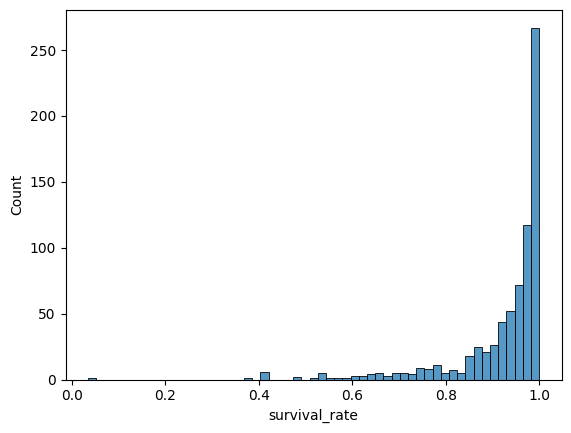

In [76]:
sns.histplot(df_cycle_harvest_mortality, x="survival_rate")

Summary
- The median survival rate is 96.7%

Note:
- Assuming all the shrimp mortality are fully recorded in the data

# Average Growth Rate per Cultivation Cycle

\begin{equation}
average\;growth\;rate=\frac{delta\;weight}{delta\;cultivation\;days}
\end{equation}

Data completeness:
- Delta weight and cultivation days can be obtained from "sampling data"

By ploting the weight (y-axis) and days (x-axis), the average growth rate can be estimated by the gradient of the formed line (linear regression)

In [126]:
df_cycle = pd.read_csv('Data/cycles.csv')
df_cycle = df_cycle[['id', 'pond_id', 'started_at', 'finished_at']].copy()
# Rename columns & change data type
df_cycle.columns = ['cycle_id', 'pond_id', 'start_date', 'finish_date']
df_cycle.start_date = pd.to_datetime(df_cycle.start_date)
df_cycle.finish_date = pd.to_datetime(df_cycle.finish_date)
# Drop duplicates and null rows
df_cycle = df_cycle.drop_duplicates()
df_cycle = df_cycle.dropna(subset=['cycle_id', 'start_date', 'finish_date'])

df_sampling = pd.read_csv('Data/samplings.csv')
df_sampling = df_sampling[['cycle_id', 'sampled_at', 'average_weight']].copy()
# Rename columns & change data type
df_sampling.columns = ['cycle_id', 'sampled_date', 'average_weight']
df_sampling = df_sampling[df_sampling.sampled_date!='1-01-01']
df_sampling.sampled_date = pd.to_datetime(df_sampling.sampled_date)
df_sampling.cycle_id = df_sampling.cycle_id.astype(int)
# Drop duplicates and null rows
df_sampling = df_sampling.drop_duplicates()
df_sampling = df_sampling.dropna(subset=['cycle_id', 'sampled_date', 'average_weight'])

# Join Data Frame
df_cycle_sampling = df_sampling.merge(df_cycle, how='inner', on=['cycle_id'])
# Validate the sampling between cycle start & finish date
df_cycle_sampling = df_cycle_sampling[(df_cycle_sampling.start_date<=df_cycle_sampling.sampled_date)&(df_cycle_sampling.finish_date>=df_cycle_sampling.sampled_date)]

# Calculate count sampling (average growth rate can only be calculated if there's at least 2 number of observations)
df_count_sampling = df_cycle_sampling[['cycle_id', 'sampled_date']].groupby('cycle_id').count().reset_index()
df_count_sampling = df_count_sampling[df_count_sampling.sampled_date > 1]

# Final data sampling
df_cycle_sampling = df_cycle_sampling.merge(df_count_sampling[['cycle_id']], how='inner', on=['cycle_id'])
df_cycle_sampling = df_cycle_sampling.sort_values(by=['cycle_id', 'sampled_date'])
# Calculate delta cultivation days
df_cycle_sampling['delta_days'] = (df_cycle_sampling['sampled_date'] - df_cycle_sampling['start_date']).dt.days
df_cycle_sampling

,cycle_id,sampled_date,average_weight,pond_id,start_date,finish_date,delta_days
8304,3458,2020-04-10,4.37,12969,2020-03-07,2020-06-27,34
8305,3458,2020-04-17,5.23,12969,2020-03-07,2020-06-27,41
8303,3458,2020-04-24,6.69,12969,2020-03-07,2020-06-27,48
8302,3458,2020-05-01,8.21,12969,2020-03-07,2020-06-27,55
8306,3458,2020-05-08,9.68,12969,2020-03-07,2020-06-27,62
...,...,...,...,...,...,...,...
5469,29874,2024-02-20,4.10,43654,2024-01-09,2024-03-25,42
5470,29874,2024-02-27,6.20,43654,2024-01-09,2024-03-25,49
5471,29874,2024-03-05,8.39,43654,2024-01-09,2024-03-25,56
5472,29874,2024-03-12,8.98,43654,2024-01-09,2024-03-25,63


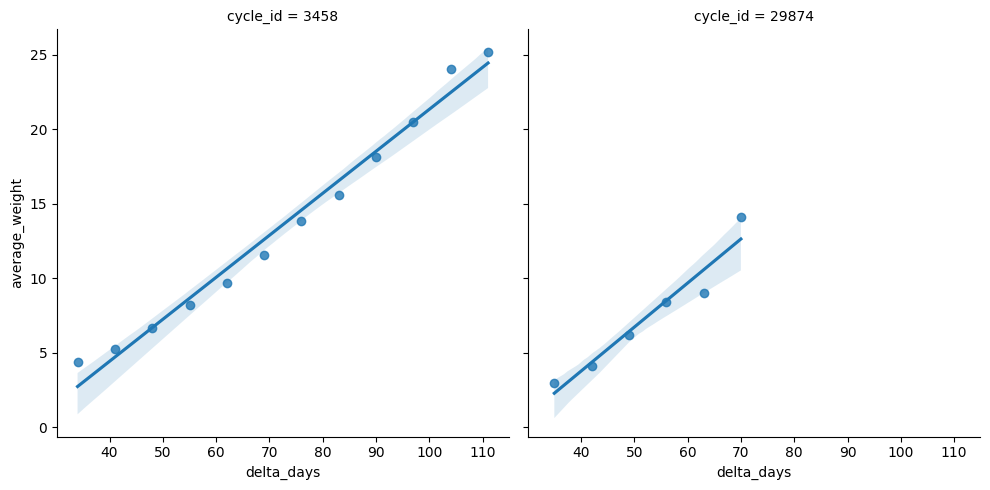

In [133]:
# Try to plot 2 cycle as sample for regression
sns.lmplot(data=df_cycle_sampling[(df_cycle_sampling.cycle_id==3458)|(df_cycle_sampling.cycle_id==29874)], 
           x="delta_days", y="average_weight", col="cycle_id")

As we can see in the plot above, the gradient line represent the growth rate of shrimp in each cycle

In [170]:
array_cycles = df_cycle_sampling.cycle_id.unique()
array_growth_rate = []
for ac in array_cycles:
    temp_row = []
    temp_df = df_cycle_sampling[df_cycle_sampling.cycle_id==ac].copy()
    X = temp_df.delta_days.values.reshape(-1,1)
    y = temp_df.average_weight.values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    temp_row = [ac, reg.coef_[0,0]]
    array_growth_rate.append(temp_row)
df_growth_rate = pd.DataFrame(array_growth_rate, columns=['cycle_id', 'average_growth_rate'])
df_growth_rate

,cycle_id,average_growth_rate
0,3458,0.282038
1,3459,0.282677
2,4038,0.276481
3,4039,0.251430
4,4044,0.264913
...,...,...
1898,29579,0.161628
1899,29619,0.186364
1900,29679,0.061000
1901,29873,0.258122


In [173]:
# Save the final data calculation
df_growth_rate.to_csv('Avg_Growth_Rate_calculation.csv', index=False)
df_growth_rate.average_growth_rate.describe()

count    1903.000000
mean        0.258965
std         0.123031
min        -0.166667
25%         0.192343
50%         0.252602
75%         0.312714
max         2.066667
Name: average_growth_rate, dtype: float64

<Axes: xlabel='average_growth_rate', ylabel='Count'>

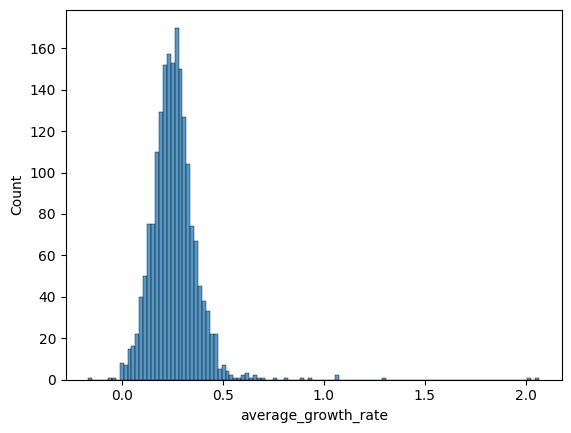

In [172]:
sns.histplot(df_growth_rate, x="average_growth_rate")

Summary
- The average growth rate is 0.25-0.26 grams per days


# Predictive: Survival Rate (SR) at pointed day

Assuming all the shrimp mortality are fully recorded in the data
\begin{equation}
survival\;rate=1-\frac{mortality\;shrimp}{seed\;shrimp}
\end{equation}

## Calculate SR

In [2]:
df_cycle = pd.read_csv('Data/cycles.csv')
df_cycle = df_cycle[['id', 'pond_id', 'started_at', 'finished_at', 'total_seed']].copy()
# Rename columns & change data type
df_cycle.columns = ['cycle_id', 'pond_id', 'start_date', 'finish_date', 'total_seed_shrimp']
df_cycle.start_date = pd.to_datetime(df_cycle.start_date)
df_cycle.finish_date = pd.to_datetime(df_cycle.finish_date)
# Drop duplicates and null rows
df_cycle = df_cycle.drop_duplicates()
df_cycle = df_cycle.dropna(subset=['cycle_id', 'start_date', 'finish_date', 'total_seed_shrimp'])

df_mortalities = pd.read_csv('Data/mortalities.csv')
df_mortalities = df_mortalities[['cycle_id', 'recorded_at', 'quantity']].copy()
# Rename columns & change data type
df_mortalities.columns = ['cycle_id', 'record_date', 'total_mortality_shrimp']
df_mortalities.record_date = pd.to_datetime(df_mortalities.record_date)
# Drop duplicates and null rows
df_mortalities = df_mortalities.drop_duplicates()
df_mortalities = df_mortalities.dropna(subset=['cycle_id', 'record_date', 'total_mortality_shrimp'])

In [3]:
# Count Mortality
df_count_mortality = df_cycle[['cycle_id', 'start_date', 'finish_date']].merge(df_mortalities, how='inner', on=['cycle_id'])
df_count_mortality = df_count_mortality[(df_count_mortality.start_date<=df_count_mortality.record_date)&(df_count_mortality.finish_date>=df_count_mortality.record_date)]
df_count_mortality = df_count_mortality.drop_duplicates()
df_count_mortality = df_count_mortality.sort_values(by=['cycle_id', 'record_date']).reset_index(drop=True)
df_count_mortality

,cycle_id,start_date,finish_date,record_date,total_mortality_shrimp
0,7273,2020-12-23,2021-03-27,2021-01-22,37400
1,7273,2020-12-23,2021-03-27,2021-02-05,2664
2,7273,2020-12-23,2021-03-27,2021-02-19,2125
3,7273,2020-12-23,2021-03-27,2021-03-05,1491
4,7276,2020-12-23,2021-03-27,2021-01-22,37400
...,...,...,...,...,...
13165,29450,2024-02-07,2024-03-17,2024-03-15,2600
13166,29450,2024-02-07,2024-03-17,2024-03-16,6500
13167,29579,2024-02-15,2024-03-26,2024-03-24,97
13168,29579,2024-02-15,2024-03-26,2024-03-25,1638


In [4]:
# Cumulative Sum of Mortality
array_ids = df_count_mortality[['cycle_id', 'record_date']].values
array_mortality = []
for id in array_ids:
    temp_row = []
    cumulative_sum = df_count_mortality[(df_count_mortality.cycle_id==id[0])&(df_count_mortality.record_date<=id[1])].total_mortality_shrimp.sum()
    temp_row = [id[0], id[1], cumulative_sum]
    array_mortality.append(temp_row)
df_sum_mortality = pd.DataFrame(array_mortality, columns=['cycle_id', 'record_date', 'total_mortality_shrimp'])
df_sum_mortality

,cycle_id,record_date,total_mortality_shrimp
0,7273,2021-01-22,37400
1,7273,2021-02-05,40064
2,7273,2021-02-19,42189
3,7273,2021-03-05,43680
4,7276,2021-01-22,37400
...,...,...,...
13165,29450,2024-03-15,2868
13166,29450,2024-03-16,9368
13167,29579,2024-03-24,97
13168,29579,2024-03-25,1735


In [5]:
# Survival Rate Calculation at certain day
df_SR = df_sum_mortality.merge(df_cycle[['cycle_id', 'pond_id', 'start_date', 'total_seed_shrimp']], how='inner', on=['cycle_id'])
# Validate total_mortality_shrimp must be less than pr equal to total_seed_shrimp
df_SR = df_SR[df_SR.total_seed_shrimp >= df_SR.total_mortality_shrimp]
df_SR['survival_rate'] = 1 - df_SR['total_mortality_shrimp'] / df_SR['total_seed_shrimp']
df_SR


,cycle_id,record_date,total_mortality_shrimp,pond_id,start_date,total_seed_shrimp,survival_rate
0,7273,2021-01-22,37400,19168,2020-12-23,75000,0.501333
1,7273,2021-02-05,40064,19168,2020-12-23,75000,0.465813
2,7273,2021-02-19,42189,19168,2020-12-23,75000,0.437480
3,7273,2021-03-05,43680,19168,2020-12-23,75000,0.417600
4,7276,2021-01-22,37400,19171,2020-12-23,75000,0.501333
...,...,...,...,...,...,...,...
13165,29450,2024-03-15,2868,45621,2024-02-07,195000,0.985292
13166,29450,2024-03-16,9368,45621,2024-02-07,195000,0.951959
13167,29579,2024-03-24,97,35864,2024-02-15,50000,0.998060
13168,29579,2024-03-25,1735,35864,2024-02-15,50000,0.965300


## Extract Features for Prediction

In [25]:
df_pond = pd.read_csv('Data/ponds.csv')
df_pond = df_pond[['id', 'length', 'width', 'deep']].copy()
# Rename columns & change data type
df_pond.columns = ['pond_id', 'length', 'width', 'deep']
df_pond['volume'] = df_pond['length'] * df_pond['width'] * df_pond['deep']
# Drop duplicates and null rows
df_pond = df_pond.drop_duplicates()
df_pond = df_pond.dropna(subset=['volume'])

# Join to data Survival Rate
df_SR = df_SR.merge(df_pond, how='left', on=['pond_id'])
df_SR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13122 entries, 0 to 13121
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   cycle_id                13122 non-null  int64         
 1   record_date             13122 non-null  datetime64[ns]
 2   total_mortality_shrimp  13122 non-null  int64         
 3   pond_id                 13122 non-null  int64         
 4   start_date              13122 non-null  datetime64[ns]
 5   total_seed_shrimp       13122 non-null  int64         
 6   survival_rate           13122 non-null  float64       
 7   length                  773 non-null    float64       
 8   width                   773 non-null    float64       
 9   deep                    773 non-null    float64       
 10  volume                  773 non-null    float64       
dtypes: datetime64[ns](2), float64(5), int64(4)
memory usage: 1.1 MB


In [7]:
df_feed = pd.read_csv('Data/feeds.csv')
df_feed = df_feed[['cycle_id', 'logged_at', 'quantity']].copy()
# # Rename columns & change data type
df_feed.columns = ['cycle_id', 'feed_datetime', 'feed_qty']
df_feed['feed_datetime'] = pd.to_datetime(df_feed['feed_datetime'])
df_feed['feed_date'] = pd.to_datetime(df_feed['feed_datetime'].dt.date)
# # Drop duplicates and null rows
df_feed = df_feed.drop_duplicates()
df_feed = df_feed.dropna()
df_feed = df_feed.sort_values(by=['cycle_id', 'feed_datetime']).reset_index(drop=True)
df_feed

,cycle_id,feed_datetime,feed_qty,feed_date
0,3458,2020-03-08 11:30:00,8.0,2020-03-08
1,3458,2020-03-09 11:30:00,20.0,2020-03-09
2,3458,2020-03-10 11:30:00,22.0,2020-03-10
3,3458,2020-03-11 11:30:00,24.0,2020-03-11
4,3458,2020-03-12 11:30:00,26.0,2020-03-12
...,...,...,...,...
551891,29874,2024-03-23 08:00:00,3.5,2024-03-23
551892,29874,2024-03-23 12:00:00,3.5,2024-03-23
551893,29874,2024-03-23 16:00:00,3.5,2024-03-23
551894,29874,2024-03-24 00:00:00,3.5,2024-03-24


In [52]:
# Count feed frequency
df_feed_freq = df_feed.groupby(by=['cycle_id', 'feed_date']).agg({
    'feed_datetime':'count', 'feed_qty': 'sum'}).reset_index()
df_feed_freq.columns = ['cycle_id', 'feed_date', 'daily_freq', 'feed_qty']

# Cumulative Sum of Feed Qty
array_ids = df_SR[['cycle_id', 'record_date', 'start_date']].values
array_feed = []
for id in array_ids:
    temp_row = []
    cumulative_sum = df_feed_freq[(df_feed_freq.cycle_id==id[0])&(df_feed_freq.feed_date>=id[2])
                                  &(df_feed_freq.feed_date<=id[1])].feed_qty.sum()
    avg_daily_freq = df_feed_freq[(df_feed_freq.cycle_id==id[0])&(df_feed_freq.feed_date>=id[2])
                                  &(df_feed_freq.feed_date<=id[1])].daily_freq.mean()
    temp_row = [id[0], id[1], id[2], cumulative_sum, avg_daily_freq]
    array_feed.append(temp_row)
df_sum_feed = pd.DataFrame(array_feed, columns=['cycle_id', 'record_date', 'start_date',
                                                'total_feed_qty', 'avg_daily_freq'])
df_sum_feed


,cycle_id,record_date,start_date,total_feed_qty,avg_daily_freq
0,7273,2021-01-22,2020-12-23,90.0,1.000000
1,7273,2021-02-05,2020-12-23,170.0,1.000000
2,7273,2021-02-19,2020-12-23,263.0,1.000000
3,7273,2021-03-05,2020-12-23,375.0,1.000000
4,7276,2021-01-22,2020-12-23,90.0,1.000000
...,...,...,...,...,...
13117,29450,2024-03-15,2024-02-07,1289.5,1.264706
13118,29450,2024-03-16,2024-02-07,1344.5,1.257143
13119,29579,2024-03-24,2024-02-15,237.5,3.315789
13120,29579,2024-03-25,2024-02-15,240.5,3.256410


In [53]:
# Join to data Survival Rate
df_SR = df_SR.merge(df_sum_feed, how='left', on=['cycle_id', 'record_date', 'start_date'])
df_SR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13844 entries, 0 to 13843
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   cycle_id                13844 non-null  int64         
 1   record_date             13844 non-null  datetime64[ns]
 2   total_mortality_shrimp  13844 non-null  int64         
 3   pond_id                 13844 non-null  int64         
 4   start_date              13844 non-null  datetime64[ns]
 5   total_seed_shrimp       13844 non-null  int64         
 6   survival_rate           13844 non-null  float64       
 7   length                  863 non-null    float64       
 8   width                   863 non-null    float64       
 9   deep                    863 non-null    float64       
 10  volume                  863 non-null    float64       
 11  total_feed_qty          13844 non-null  float64       
 12  avg_daily_freq          13844 non-null  float6

Since there are too many empty data for ponds, I won't use the data (drop columns)

In [54]:
df_SR = df_SR.drop(columns=['pond_id', 'length', 'width', 'deep', 'volume'])

In [62]:
# Remove data with total_feed_qty = 0 or avg_daily_freq = 0
df_SR = df_SR[(df_SR.total_feed_qty>0)&(df_SR.avg_daily_freq>0)]
df_SR['days_cultivation'] = (df_SR['record_date'] - df_SR['start_date']).dt.days
df_SR['remaining_shrimp'] = df_SR['total_seed_shrimp'] - df_SR['total_mortality_shrimp']
df_SR['avg_daily_feed_qty'] = df_SR['total_feed_qty'] / df_SR['days_cultivation']
df_SR = df_SR[['cycle_id', 'record_date', 'survival_rate', 'remaining_shrimp',
               'total_seed_shrimp', 'days_cultivation', 'avg_daily_freq',
               'total_feed_qty', 'avg_daily_feed_qty']]
df_SR.head()

,cycle_id,record_date,survival_rate,remaining_shrimp,total_seed_shrimp,days_cultivation,avg_daily_freq,total_feed_qty,avg_daily_feed_qty
0,7273,2021-01-22,0.501333,37600,75000,30,1.0,90.0,3.000000
1,7273,2021-02-05,0.465813,34936,75000,44,1.0,170.0,3.863636
2,7273,2021-02-19,0.437480,32811,75000,58,1.0,263.0,4.534483
3,7273,2021-03-05,0.417600,31320,75000,72,1.0,375.0,5.208333
4,7276,2021-01-22,0.501333,37600,75000,30,1.0,90.0,3.000000


## Predictive Model

First, we need to identify outliers:
* The histogram of avg_daily_freq should similar with normal distribution --> because it's showing normal behavior condition of feeding frequency
* The histogram of average feed per shrimp per day should also similar with normal distribution --> because it's showing normal eating behavior of shrimp

In [186]:
df_SR['eating_per_shrimp_per_day'] = df_SR["total_feed_qty"] / (df_SR["total_seed_shrimp"] * df_SR["days_cultivation"])

<Axes: xlabel='avg_daily_freq', ylabel='Count'>

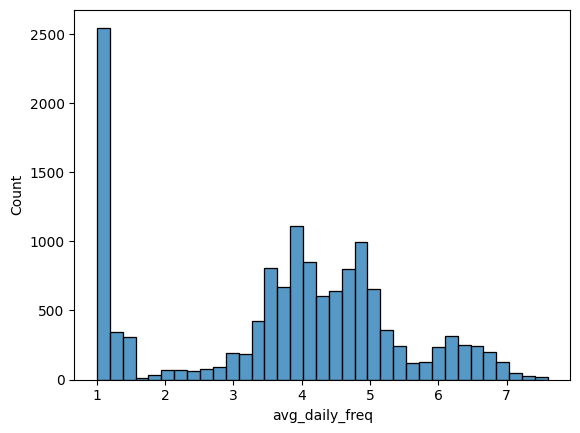

In [187]:
sns.histplot(x=df_SR["avg_daily_freq"])

<Axes: xlabel='eating_per_shrimp_per_day', ylabel='Count'>

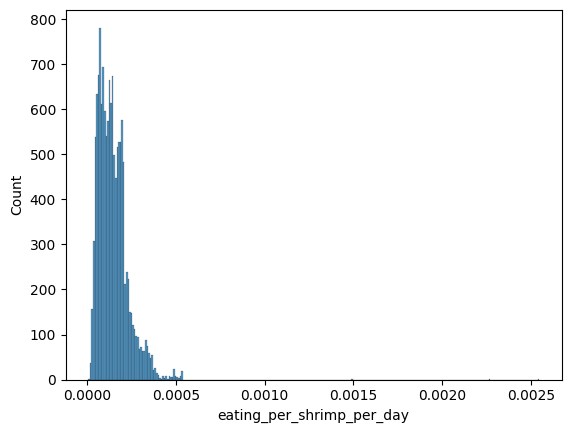

In [188]:
sns.histplot(x = df_SR['eating_per_shrimp_per_day'])

<Axes: ylabel='eating_per_shrimp_per_day'>

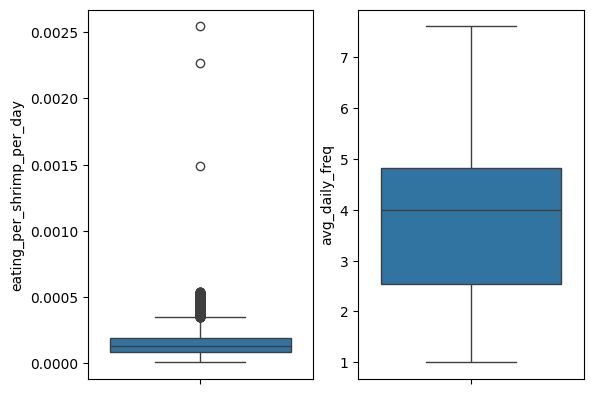

In [190]:
figure, axs = plt.subplots(1,2)
sns.boxplot(y=df_SR["avg_daily_freq"], ax=axs[1])
sns.boxplot(y=df_SR['eating_per_shrimp_per_day'], ax=axs[0])

As we can see in the boxplot above, there's outlier in the eating behavior of the shrimp. We need to exclude this by capping the value of percentile 95%

<Axes: xlabel='eating_per_shrimp_per_day'>

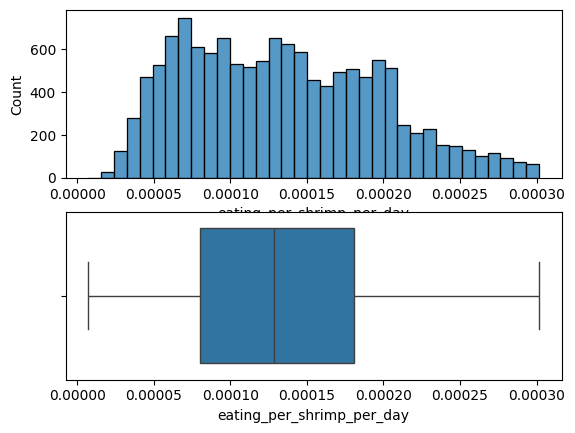

In [201]:
percentile_95 = df_SR['eating_per_shrimp_per_day'].quantile(0.95)
figure, axs = plt.subplots(2,1)
sns.histplot(x = df_SR[df_SR['eating_per_shrimp_per_day'] <= percentile_95]['eating_per_shrimp_per_day'], ax=axs[0])
sns.boxplot(x = df_SR[df_SR['eating_per_shrimp_per_day'] <= percentile_95]['eating_per_shrimp_per_day'], ax=axs[1])

In [202]:
df_SR_cleaned = df_SR[df_SR['eating_per_shrimp_per_day'] <= percentile_95].copy()

In [203]:
final_columns = ['survival_rate', 'remaining_shrimp',
                 'total_seed_shrimp', 'days_cultivation', 'avg_daily_freq',
                 'total_feed_qty', 'avg_daily_feed_qty']
df_SR_cleaned[final_columns].corr()

,survival_rate,remaining_shrimp,total_seed_shrimp,days_cultivation,avg_daily_freq,total_feed_qty,avg_daily_feed_qty
survival_rate,1.000000,0.336388,0.173730,0.024431,0.085729,0.236407,0.289900
remaining_shrimp,0.336388,1.000000,0.980513,0.106926,0.103390,0.615311,0.779738
total_seed_shrimp,0.173730,0.980513,1.000000,0.107467,0.085500,0.600497,0.762239
days_cultivation,0.024431,0.106926,0.107467,1.000000,0.149310,0.706338,0.495062
avg_daily_freq,0.085729,0.103390,0.085500,0.149310,1.000000,0.149347,0.152439
total_feed_qty,0.236407,0.615311,0.600497,0.706338,0.149347,1.000000,0.934014
avg_daily_feed_qty,0.289900,0.779738,0.762239,0.495062,0.152439,0.934014,1.000000


<Axes: xlabel='days_cultivation', ylabel='survival_rate'>

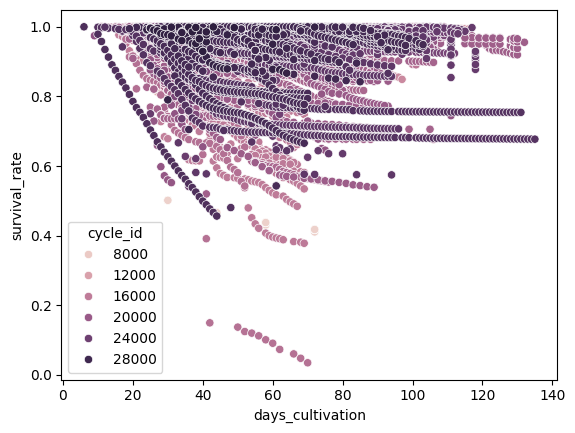

In [204]:
sns.scatterplot(df_SR_cleaned, x="days_cultivation", y="survival_rate", hue="cycle_id")

From the figure above, we can see that there's a certain factor that makes survival rate drops the longer we culvitate the shrimps.

My hypothesis: It's related to the feeding behavior & pond environment

Unfotunately we don't have enough data for pond environment. Thus, we can only use the feeding behavior

\begin{equation}
survival\;rate=1-decay\;function\;\;effect\;from\;cultivation\;days\;feeding\;behavior\;and\;shrimp\;initial\;seed\
\end{equation}

\begin{equation}
survival\;rate=1-A*cultivation\;days^B*feed\;quantity^C*initial\;seed^D*feed\;frequency^E
\end{equation}

where A, B, C, D, and E are constant

\begin{equation}
ln(1-survival\;rate)=ln(A*cultivation\;days^B*feed\;quantity^C*initial\;seed^D*feed\;frequency^E)
\end{equation}

\begin{equation}
ln(1-survival\;rate)=ln(A)+B*ln(cultivation\;days)+C*ln(feed\;quantity)+D*ln(initial\;seed)+E*ln(feed\;frequency)
\end{equation}

A, B, C, D, E can be obtained by performing linear regression following this form:

\begin{equation}
y=ln(A)+B*X_1+C*X_2+D*X_3+E*X_4
\end{equation}

In [210]:
temp_df = df_SR_cleaned.copy()
temp_df['y'] = np.log(1-temp_df['survival_rate'])
temp_df['X1'] = np.log(temp_df['days_cultivation'])
temp_df['X2'] = np.log(temp_df['total_feed_qty'])
temp_df['X3'] = np.log(temp_df['total_seed_shrimp'])
temp_df['X4'] = np.log(temp_df['avg_daily_freq'])

# Split Training and Test
X = temp_df[['X1', 'X2', 'X3', 'X4']].copy()
y = temp_df[['y']].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

reg = LinearRegression().fit(X_train, y_train)
print(reg.coef_)
print(reg.intercept_)
print(np.exp(reg.intercept_[0]))

[[ 5.78146643 -2.28114543  1.66948846 -0.19315388]]
[-31.33305622]
2.4673262685338152e-14


Thus, we have:
\begin{equation}
A=e^{-31.33305622}
\end{equation}

\begin{equation}
B=5.78146643
\end{equation}

\begin{equation}
C=-2.28114543
\end{equation}

\begin{equation}
D=1.66948846
\end{equation}

\begin{equation}
E=-0.19315388
\end{equation}

\begin{equation}
survival\;rate=1-2.467e^{-14} *cultivation\;days^{5.781}*feed\;quantity^{-2.281}*initial\;seed^{1.669}*feed\;frequency^{-0.193}
\end{equation}

In [222]:
temp_df['SR_predict'] = (1 - np.exp(reg.intercept_[0]) * 
                         np.pow(temp_df['days_cultivation'], reg.coef_[0,0]) * 
                         np.pow(temp_df['total_feed_qty'], reg.coef_[0,1]) * 
                         np.pow(temp_df['total_seed_shrimp'], reg.coef_[0,2]) * 
                         np.pow(temp_df['avg_daily_freq'], reg.coef_[0,3]) )
# If the prediction resulting negative value, I cap it to 0
temp_df['SR_predict'] = (temp_df['SR_predict']>0)*temp_df['SR_predict']
print("RMSE: ", root_mean_squared_error(temp_df['survival_rate'], temp_df['SR_predict']))
print("MAE: ", mean_absolute_error(temp_df['survival_rate'], temp_df['SR_predict']))
temp_df

RMSE:  0.10100180787930743
MAE:  0.051047361962683


,cycle_id,record_date,survival_rate,remaining_shrimp,total_seed_shrimp,days_cultivation,avg_daily_freq,total_feed_qty,avg_daily_feed_qty,eating_per_shrimp_per_day,y,X1,X2,X3,X4,SR_predict
0,7273,2021-01-22,0.501333,37600,75000,30,1.000000,90.0,3.000000,0.000040,-0.695817,3.401197,4.499810,11.225243,0.000000,0.958970
1,7273,2021-02-05,0.465813,34936,75000,44,1.000000,170.0,3.863636,0.000052,-0.627010,3.784190,5.135798,11.225243,0.000000,0.911961
2,7273,2021-02-19,0.437480,32811,75000,58,1.000000,263.0,4.534483,0.000060,-0.575329,4.060443,5.572154,11.225243,0.000000,0.839301
3,7273,2021-03-05,0.417600,31320,75000,72,1.000000,375.0,5.208333,0.000069,-0.540598,4.276666,5.926926,11.225243,0.000000,0.750281
4,7276,2021-01-22,0.501333,37600,75000,30,1.000000,90.0,3.000000,0.000040,-0.695817,3.401197,4.499810,11.225243,0.000000,0.958970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13839,29450,2024-03-15,0.985292,192132,195000,37,1.264706,1289.5,34.851351,0.000179,-4.219385,3.610918,7.162010,12.180755,0.234840,0.998503
13840,29450,2024-03-16,0.951959,185632,195000,38,1.257143,1344.5,35.381579,0.000181,-3.035700,3.637586,7.203777,12.180755,0.228842,0.998410
13841,29579,2024-03-24,0.998060,49903,50000,38,3.315789,237.5,6.250000,0.000125,-6.245067,3.637586,5.470168,10.819778,1.198696,0.992908
13842,29579,2024-03-25,0.965300,48265,50000,39,3.256410,240.5,6.166667,0.000123,-3.361016,3.663562,5.482720,10.819778,1.180625,0.991963


(0.0, 1.0)

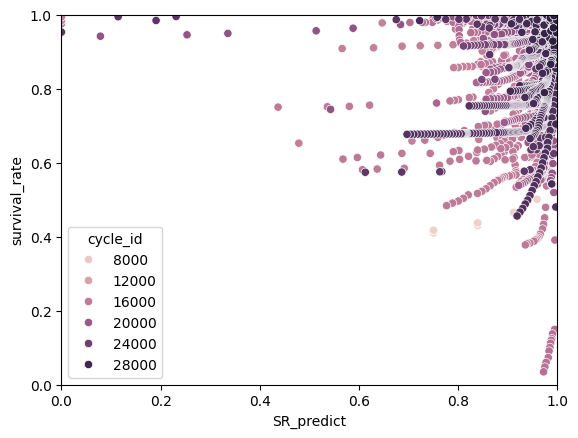

In [225]:
sns.scatterplot(temp_df, x="SR_predict", y="survival_rate", hue="cycle_id")
plt.xlim(0, 1)
plt.ylim(0, 1)

In [226]:
df_predict_SR = temp_df[['cycle_id', 'record_date', 'survival_rate', 'SR_predict']].copy()
df_predict_SR.to_csv('SR_predict.csv', index=False)

Evaluation Metrics:
* RMSE = 10.10%
* MAE = 5.10%

As we can see from the plot, our decay function still not perfect because most of the prediction is still higher than the actual SR.

I think by adding pond condition and do trial-and-error for decay function will improve the prediction (need more time to explore this)

\begin{equation}
survival\;rate=1-2.467e^{-14} *cultivation\;days^{5.781}*feed\;quantity^{-2.281}*initial\;seed^{1.669}*feed\;frequency^{-0.193}
\end{equation}

From the formula above, we can infer that:
* Feeding condition has positive impact to the SR --> higher feeding value will decrease the decay function (power by negative number as a constant)
* Cultivation days & Initial seed has negative impact to the SR --> higher days & seed value will increase the decay function (power by positive number as a constant)

By the power constant, we can see that cultivation days has the highest one (+5.781). Thus this is one of the most important features. And the least important one is feeding frequency (how many times feeding happened in a day).

Thus, to achieve the maximum result of shrimp harvesting, we need to understand the optimum harvest time (cultivation days). Initial seed and feeding behavior are something that the farmers can control and depends on their effort & initial funds. By insert the feeding beahvior & initial seed to the formula above, we can evaluaate if we consider having survival rate of certain value, we need to harvest them at specific date.

# Average Body Weight, Biomass, Revenue

Since I don't have enough time to finish the test, I will just give the rough ideas.
1. Average Body Weight:

The rough method will be similar with the SR prediction, I will use regression if possible because it will give me a rough formula which can be understand easily. And by having mathematics formula, we can control what variable that we want to optimize later on to achieve the best result of shrimp harvesting.

Feature that I consider to be included are:
* Initial weight of shrimp (seed)
* Cultivation days
* Feeding behavior: quantity & frequency
* Pond & water condition (if possible)
* Shrimp density which indicate the empty space for shrimp to move freely (if possible)

While the predicted variable will be:
* Average weight from sampling at certain days (from data samplings.csv)

-------------------------------------- o0o --------------------------------------

2. Biomass:

To be honest I don't really get what kind of biomass that you expected here because there's no column called "biomass" in the provided dataset. Thus, I think the data isn't complete and I can't do the prediction for this.

-------------------------------------- o0o --------------------------------------

3. Revenue:

For the revenue it will be quite complicated. My idea is combining the SR prediction and Average Body Weight prediction that we've build before.
* The SR prediction will give us an idea at certain cultivation days we will obtain N shrimp to be harvested (%SR times initial seed)
* The Average Body Weight prediction will give us an idea at certain cultivation days we weill obtain shrimp with M body weight and estimate their price based on the size

Thus, at the end we can have Selling price as function of N (number of shrimp) and M (shrimp body weight):

Selling price = N * price per shrimp (at certain size of M body weight)

Revenue = Selling price - initial fund (buying the seed) - feeding & maintain pond water condition cost